# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

In [2]:
pybamm.__version__

'23.9'

In [3]:
from ecm.autofit_jellyroll import get_spiral_params, get_cell_areal_capacity, estimate_nominal_capacity

## First getting the parameter values

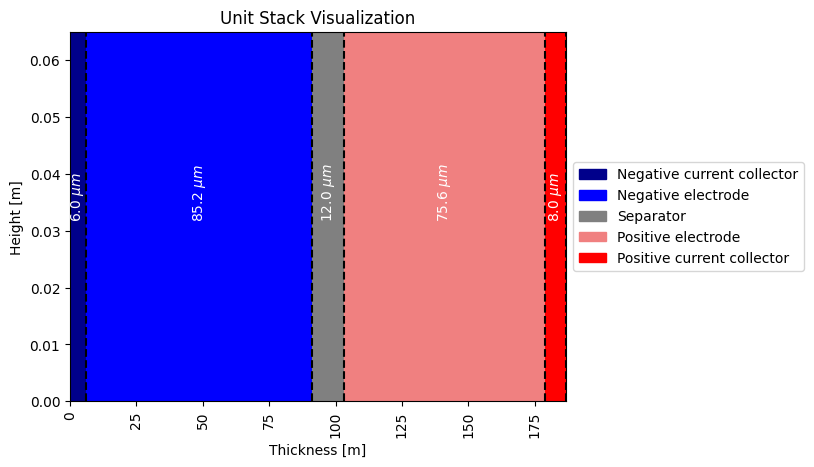

In [55]:
from bpechem.plot import visualize_unit_stack
visualize_unit_stack(params)

In [4]:
def get_unit_stack_thickness(parameters):
    electrode_thickness_p = parameters["Positive electrode thickness [m]"]
    electrode_thickness_n = parameters["Negative electrode thickness [m]"]
    cc_thickness_n = parameters["Negative current collector thickness [m]"] / 2
    cc_thickness_p = parameters["Positive current collector thickness [m]"] / 2 
    separator_thickness = parameters["Separator thickness [m]"]
    return electrode_thickness_p + electrode_thickness_n + cc_thickness_n + cc_thickness_p + separator_thickness


In [5]:
params = pybamm.ParameterValues("Ai2020")

get_unit_stack_thickness(params)

params.search('height')
params.search('Negative electrode thickness')

params["Positive electrode thickness [m]"] = params["Positive electrode thickness [m]"] * 0.7
params["Negative electrode thickness [m]"] = params["Negative electrode thickness [m]"] * 0.7

Electrode height [m]	0.051
Negative electrode thickness [m]	7.65e-05


In [6]:
def get_estimated_diameter(spacing, Nlayers):
    return (((Nlayers*2) + 1.4)*spacing + 10*spacing ) * 2

In [7]:
import math

def calculate_spiral(inner_diameter, outer_diameter, layer_thickness):
    a = layer_thickness
    phi_1 = outer_diameter * math.pi / a
    phi_2 = inner_diameter * math.pi / a
    n = (phi_1 - phi_2) / (2 * math.pi)
    L = (
        (a/(2*math.pi)) 
        * (
            (phi_1/2)* (phi_1**2 + 1)**(1/2)
            + (1/2)*math.log(phi_1 + (phi_1**2 + 1)**(1/2))
            - (phi_2/2)* (phi_2**2 + 1)**(1/2)
            - (1/2)*math.log(phi_2 + (phi_2**2 + 1)**(1/2))
        )
    )
    return n, L


calculate_spiral(0.0035, 0.018, 186e-6)



(38.978494623655905, 1.31641067625418)

In [8]:
spacing = get_unit_stack_thickness(params)
print(spacing)

get_estimated_diameter(spacing, 20)

0.00013865


0.01425322

In [9]:
from typing import Literal

def get_cell_areal_capacity(parameters: dict, electrode:Literal['positive','negative','cell'],phase:Literal['','Primary: ','Secondary: ']|None=''):
    if phase is None:
        phase = ''
    elif phase == 'Primary:':
        phase = 'Primary: '
    elif phase == 'Secondary:':
        phase = 'Secondary: '
    if electrode == 'cell':
        electrode = 'positive'
    # if 'Primary: Maximum concentration in negative electrode [mol.m-3]' in parameters:
    positive_csmax = parameters[f'{phase}Maximum concentration in {electrode.lower()} electrode [mol.m-3]']
    positive_volfrac = parameters[f'{phase}{electrode.capitalize()} electrode active material volume fraction']
    positive_thickness = parameters[f'{electrode.capitalize()} electrode thickness [m]']
    positive_correction, negative_correction = get_SOC_window_correction_factor(pybamm.ParameterValues(parameters))
    if electrode == 'positive':
        correction = positive_correction
    elif electrode == 'negative':
        correction = negative_correction
    elif electrode == 'cell':
        correction = positive_correction
    areal_capacity = (
        (positive_csmax * positive_thickness * positive_volfrac * 96485)/
        (3.6 * 100**2)
        *(correction)
    )
    return areal_capacity

def get_SOC_window_correction_factor(params):
    '''
    Returns the correction factor for the SOC window of the cell. This is used to correct the cell capacity to account for the fact that the cell's SOC window is not 0-100% SOC. The correction factor is calculated by solving the electrode SOH model and finding the difference in the electrode capacity at 0% and 100% SOC. The correction factor is then used to scale the nominal capacity of the cell to account for the SOC window.

    _extended_summary_

    Args:
        params (pybamm.ParameterValues): The parameter set for the cell model

    Returns:
        tuple[float, float]: The positive, negative correction factors
    '''
    if isinstance(params,dict):
        params = pybamm.ParameterValues(params)
    param = pybamm.LithiumIonParameters()

    Vmin = params['Open-circuit voltage at 0% SOC [V]']
    Vmax = params['Open-circuit voltage at 100% SOC [V]']
    Q_n = params.evaluate(param.n.Q_init)
    Q_p = params.evaluate(param.p.Q_init)
    Q_Li = params.evaluate(param.Q_Li_particles_init)

    inputs = {"V_min": Vmin, "V_max": Vmax, "Q_n": Q_n, "Q_p": Q_p, "Q_Li": Q_Li}


    esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(params, param)

    esoh_solver = esoh_solver.solve(inputs)

    correction_factor_p = esoh_solver['y_0'] - esoh_solver['y_100']
    correction_factor_n = esoh_solver['x_100'] - esoh_solver['x_0']

    return correction_factor_p, correction_factor_n

In [10]:
pip install icecream

Note: you may need to restart the kernel to use updated packages.


In [11]:
from icecream import ic

In [12]:
def get_spiral_params(parameter_values, form_factor='18650'):
    spacing = get_unit_stack_thickness(parameter_values)
    print(f'Unit stack thickness: {spacing*1e6} um')
    if form_factor == '18650':
        inner_diameter = 0.0035
        outer_diameter = 0.018
    else:
        raise ValueError("form_factor must be '18650' or 'pouch'")
    
    Nlayers, L = calculate_spiral(inner_diameter, outer_diameter, spacing)
    print('Nlayers', Nlayers, 'L', L)
    # nominal_area = parameter_values['Electrode height [m]'] * parameter_values['Electrode width [m]']
    length_3d = 0.065
    dtheta = 15
    tesla_tabs = False
    import math
    project, arc_edges = ecm.make_spiral_net(math.floor(Nlayers/2),
                                         dtheta,
                                         spacing,
                                         inner_diameter,
                                         [-1],
                                         [0],
                                         length_3d,
                                         tesla_tabs)
    
    return project, arc_edges

def get_electrode_height(project):
    net = project.network
    return net["throat.electrode_height"][net.throats("throat.spm_resistor")].sum()

def estimate_nominal_capacity(project, parameter_values):
    electrode_height = get_electrode_height(project)
    ic(electrode_height)
    # print('height', electrode_height, parameter_values['Electrode width [m]'])
    ic(parameter_values['Electrode width [m]'])
    ic(parameter_values['Electrode height [m]'])
    actual_area = electrode_height * 0.065
    ic(actual_area)
    nominal_area = parameter_values['Electrode height [m]'] * parameter_values['Electrode width [m]']
    ic(nominal_area)
    # print('area', actual_area, nominal_area)
    nominal_capacity = get_cell_areal_capacity(parameter_values, 'negative')
    ic(nominal_capacity)
    # print('estimated cell areal capacity from params', nominal_capacity)
    areal_capacity = parameter_values["Nominal cell capacity [A.h]"] / nominal_area
    ic(areal_capacity)
    # return areal_capacity * actual_area
    return nominal_area * electrode_height * 1e3
    

In [13]:
get_cell_areal_capacity(params, 'positive')

2.118336330661629

In [14]:
params = pybamm.ParameterValues("Ai2020")
# params.update({'Positive electrode thickness [m]': 50e-6, 'Negative electrode thickness [m]': 50e-6})
params.search('stack thickness')
project, arc_edges = get_spiral_params(params)

params.search('Nominal cell capacity')
cap = estimate_nominal_capacity(project, params)
print('estimated capacity', cap)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-28 14:05:40,940
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-28 14:05:40,973
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-28 14:05:40,980
------------------------------------------------------------


No results for search using 'stack thickness'. Best matches are ['Separator thickness [m]', 'Positive electrode thickness [m]', 'Initial outer SEI thickness [m]']
Unit stack thickness: 182.0 um
Nlayers 39.83516483516483 L 1.3453417250817978
Nominal cell capacity [A.h]	2.28


ic| electrode_height: 1.6581289373732635
ic| parameter_values['Electrode width [m]']: 0.047
ic| parameter_values['Electrode height [m]']: 0.051
ic| actual_area: 0.10777838092926213
ic| nominal_area: 0.002397
ic| nominal_capacity: 3.026194758088041
ic| areal_capacity: 951.188986232791


estimated capacity 3.9745350628837124


In [15]:
# Experiment
Crate = 1
I_app = Crate * cap
dt = 5
Nsteps = 1000
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
        # f"Charge at {I_app} A for {hours} hours or until 4.2 V",
    ],
    period=f"{dt} seconds",
)

In [16]:

# Parameter set
param = params
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = 0.065
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(ecm.lump_thermal_props(param))



{'alpha_radial': 0.00017117077295252816, 'alpha_spiral': 0.0013256599794981118, 'lump_rho': 2046.5340350525876, 'lump_Cp': 7583.284885867839}


In [17]:
trans_kwargs = {'t_slice':10,'t_precision':1}

# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=None,
                                        project=project,
                                        **trans_kwargs)

Initialising simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Stepping simulation:  10%|▉         | 100/1001 [04:10<35:24,  2.36s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10f491600>>
Traceback (most recent call last):
  File "/Users/tleo/micromamba/envs/pnm_dev_pinned_intel/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Stepping simulation:  10%|█         | 105/1001 [04:22<33:22,  2.24s/it]

In [1]:
lp.plot_output(output)

NameError: name 'lp' is not defined

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-23 17:41:27,777
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-23 17:41:27,799
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-23 17:41:27,809
------------------------------------------------------------


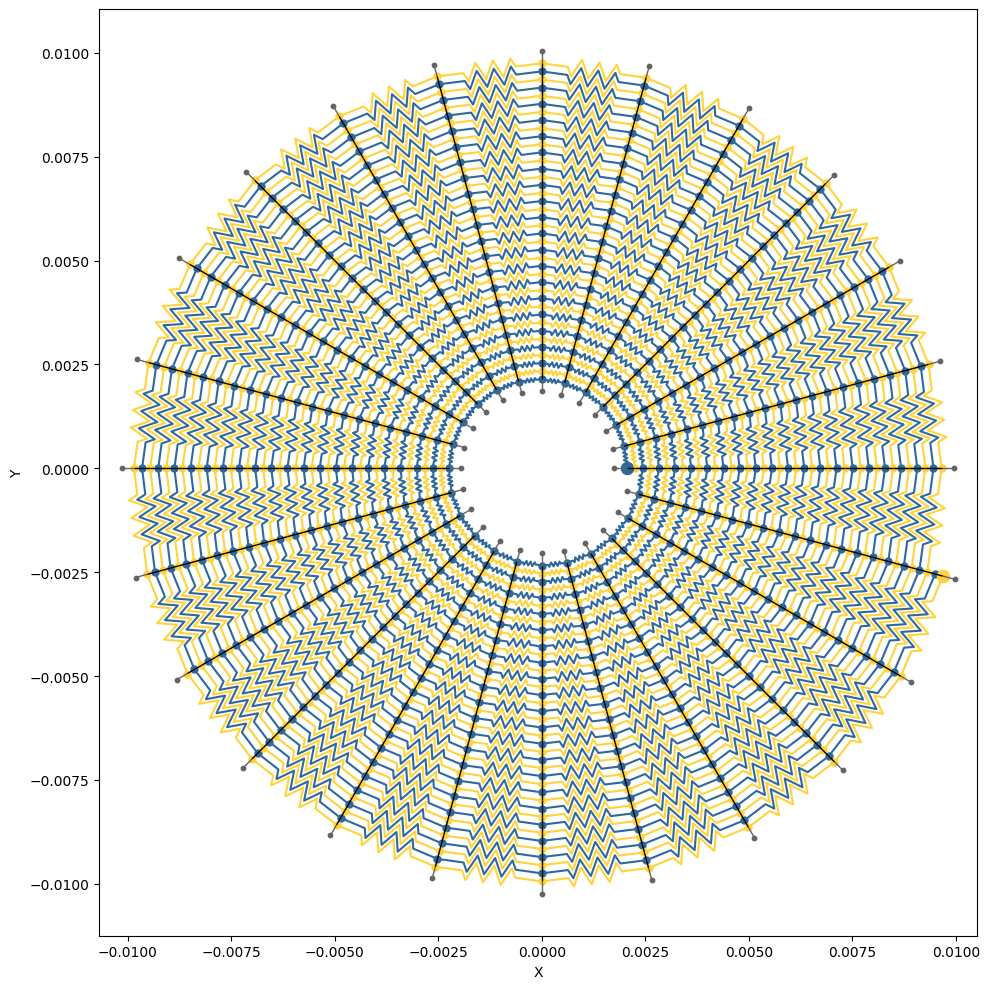

In [191]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

# Geometry of spiral
Nlayers = 20
dtheta = 15
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 1000
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
        # f"Charge at {I_app} A for {hours} hours or until 4.2 V",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)
ecm.plot_topology(project.network)



In [192]:
print(project.network)

mask = project.network['pore.pos_tab']

project.network['pore.radial_position'][mask] * 2

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.Cubic : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.arc_index                                 1008 / 1008 
2     pore.cell_id                                   1008 / 1008 
3     pore.coords                                    1008 / 1008 
4     pore.radial_position                           1008 / 1008 
5     pore.region_id                                 1008 / 1008 
6     throat.arc_length                              1942 / 1942 
7     throat.conns                                   1942 / 1942 
8     throat.spm_resistor_order                      1894 / 1942 
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned

array([0.0200525])

In [193]:
net = project.network
net["throat.electrode_height"][net.throats("throat.spm_resistor")].sum()

1.4793013677499107

In [162]:
params.search('width')
params.search('height')

Electrode width [m]	1.58
Electrode height [m]	0.065


In [172]:
1.58*0.065

# 1.4793 * 0.08

0.10270000000000001

In [82]:
(41.4*spacing + 10*spacing ) * 2

0.19203040000000002

In [6]:

# Parameter set
param = pybamm.ParameterValues("Chen2020")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(ecm.lump_thermal_props(param))



{'alpha_radial': 0.00012997486546235373, 'alpha_spiral': 0.0018925822276459076, 'lump_rho': 2499.316300105252, 'lump_Cp': 8247.24639489116}


/Users/tleo/micromamba/envs/pnm_dev_pinned_intel/lib/python3.10/site-packages/pybamm/models/full_battery_models/base_battery_model.py:910: OptionWarning: The 'lumped' thermal option with 'dimensionality' 0 now uses the parameters 'Cell cooling surface area [m2]', 'Cell volume [m3]' and 'Total heat transfer coefficient [W.m-2.K-1]' to compute the cell cooling term, regardless of the value of the the 'cell geometry' option. Please update your parameters accordingly.
  options = BatteryModelOptions(extra_options)
Initialising simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Stepping simulation:  14%|█▎        | 137/1001 [02:01<12:43,  1.13it/s]


KeyboardInterrupt: 

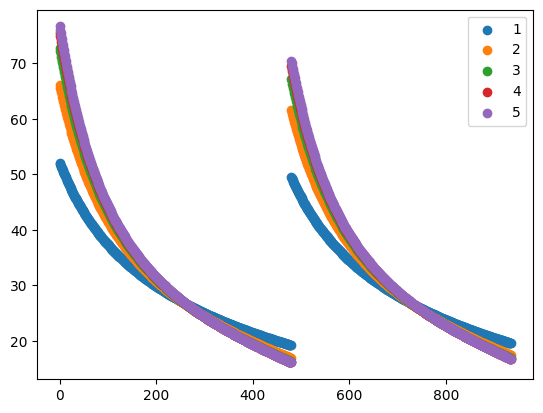

In [7]:
trans_kwargs = {'t_slice':10,'t_precision':1}

# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=None,
                                        project=project,
                                        **trans_kwargs)

In [9]:
net = project.network
net.num_pores('free_stream')

24

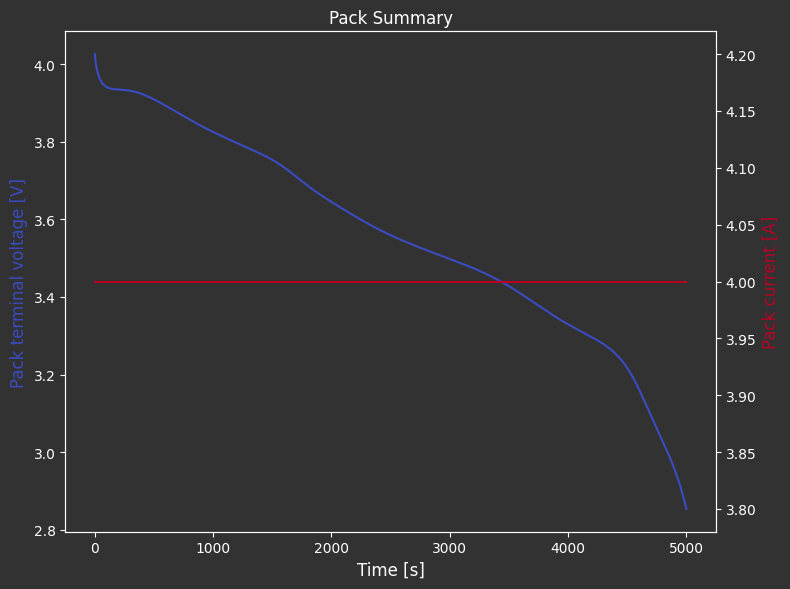

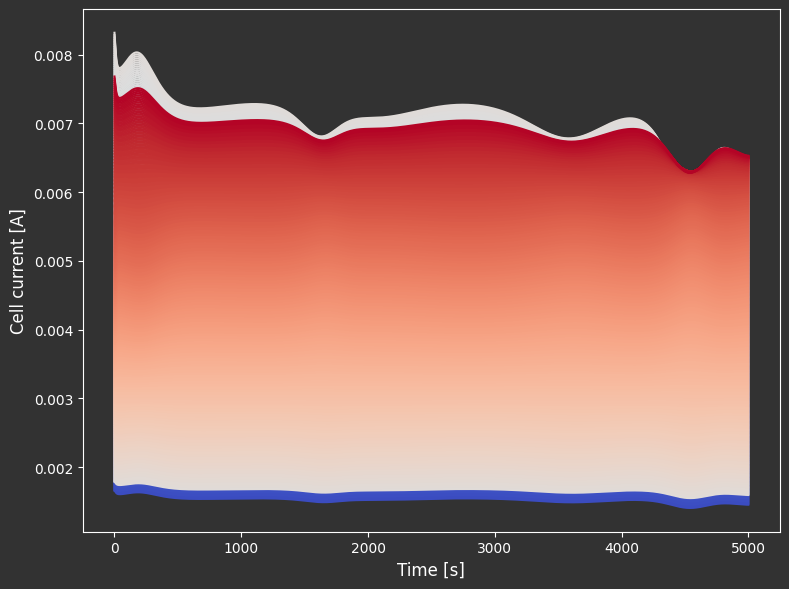

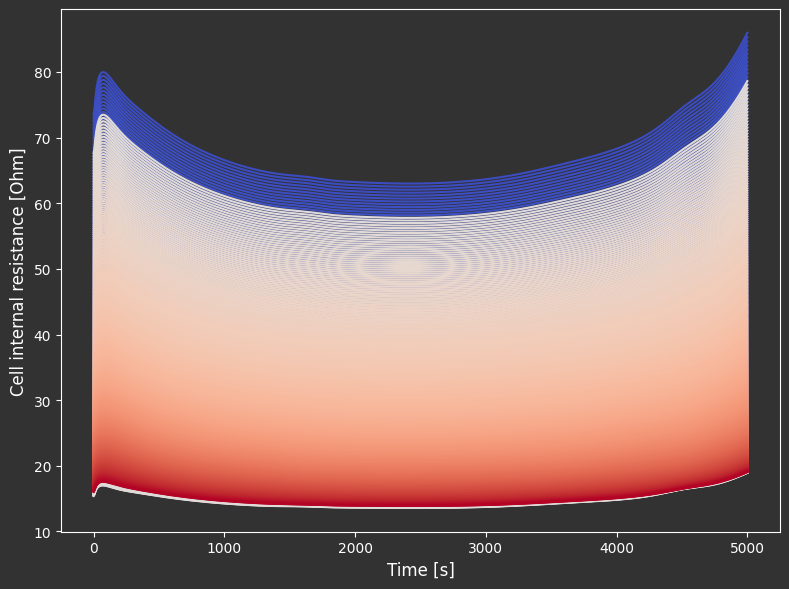

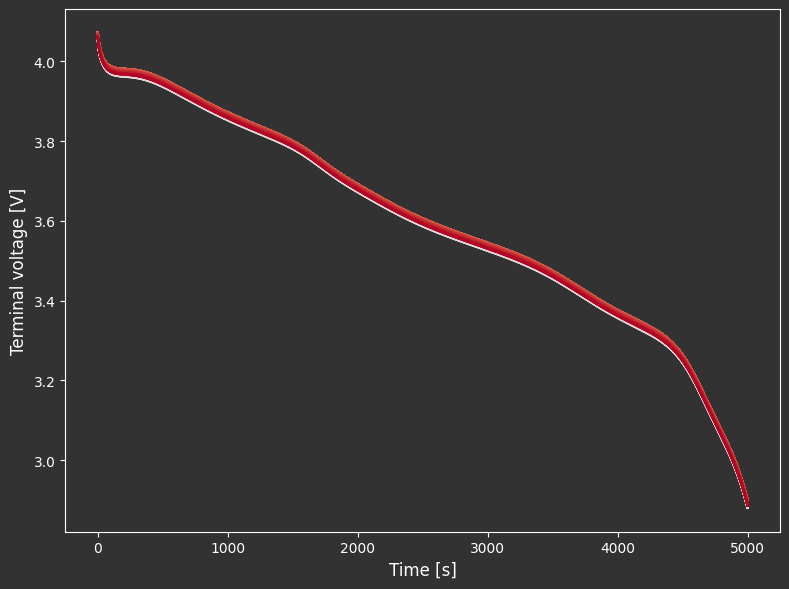

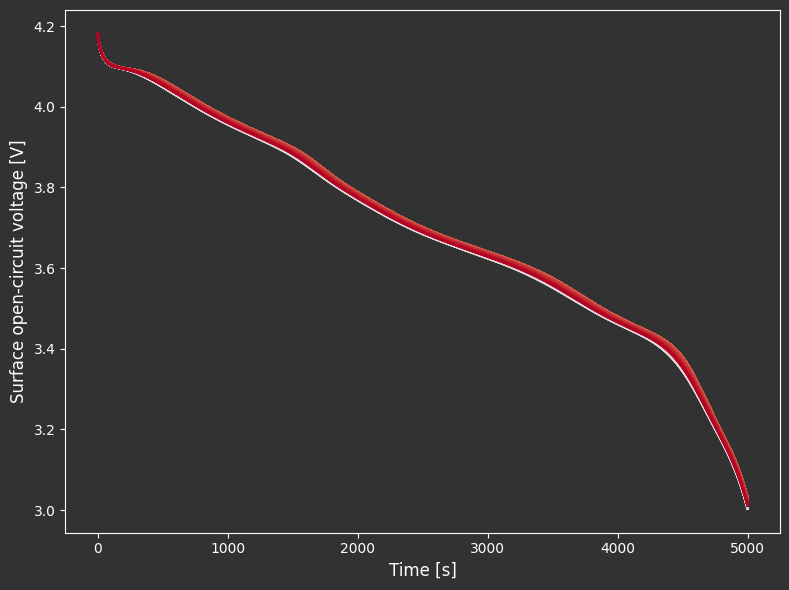

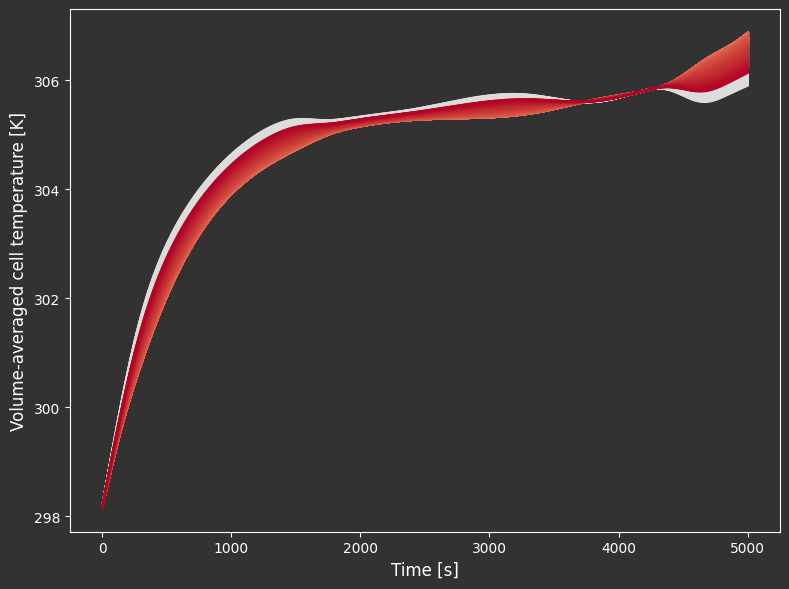

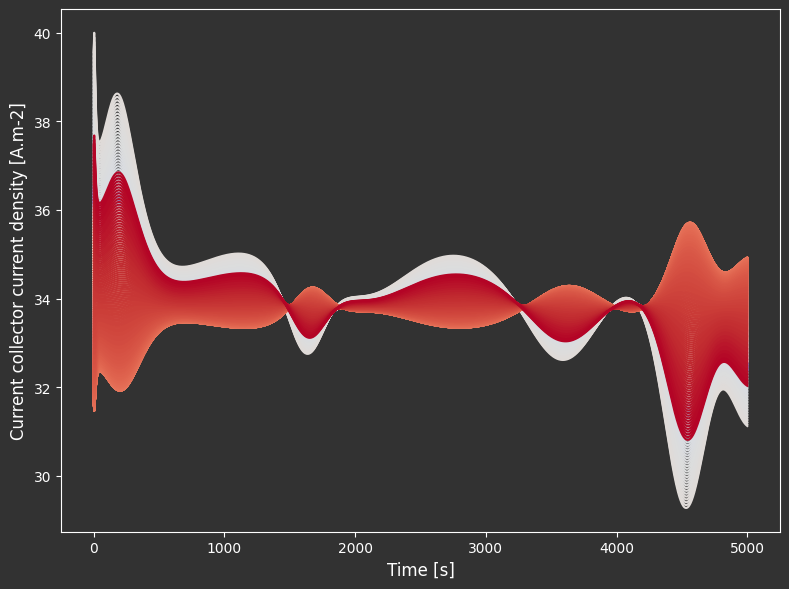

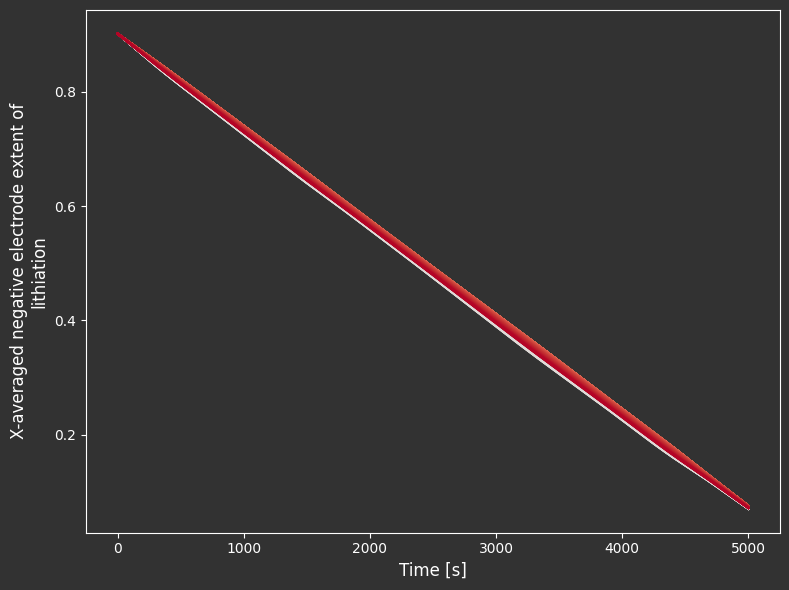

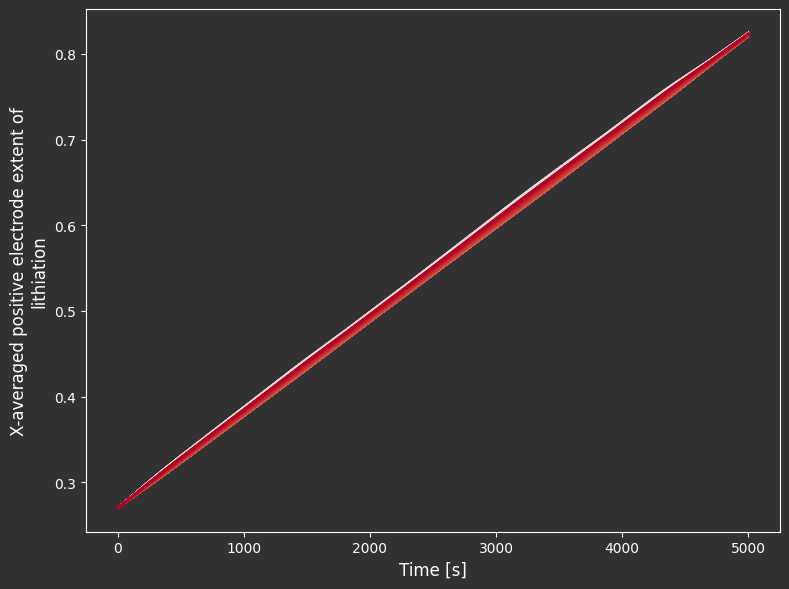

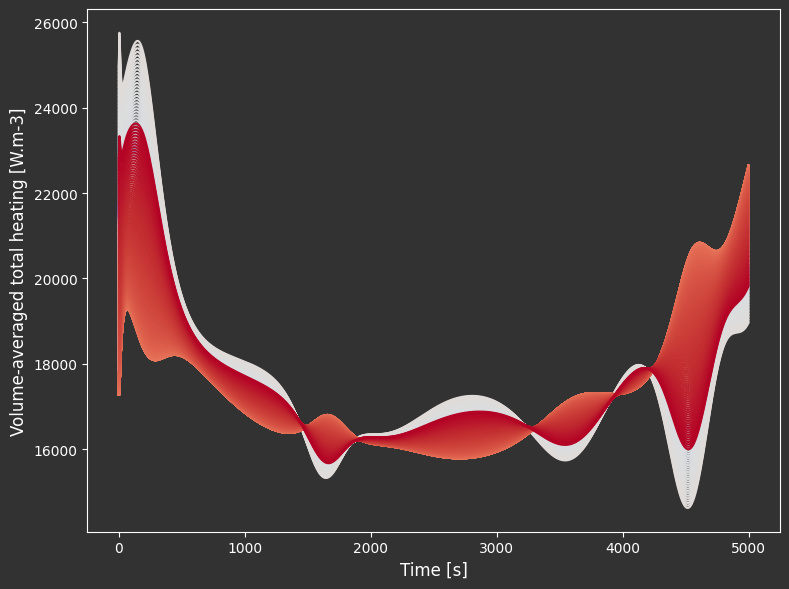

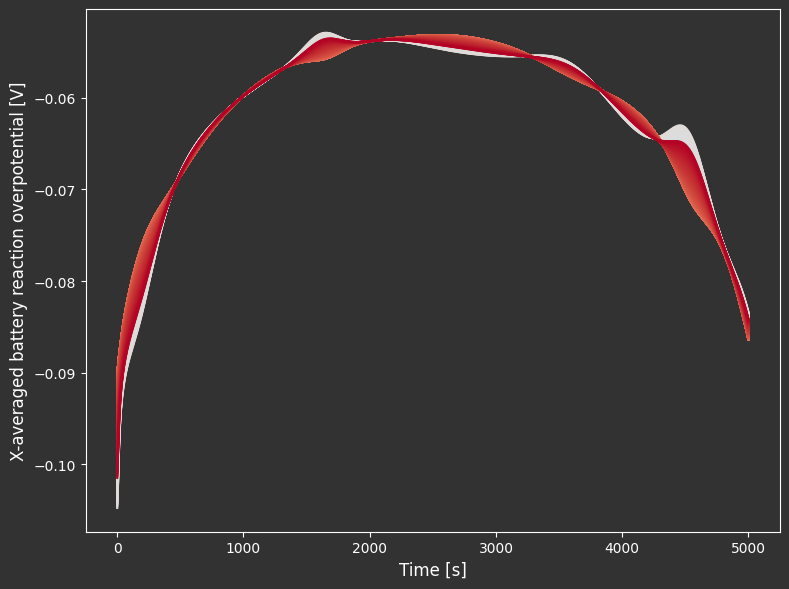

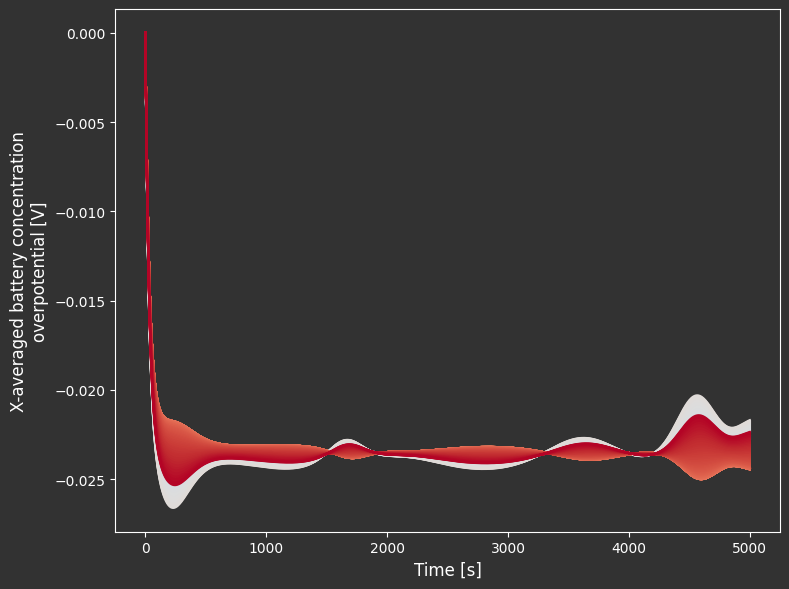

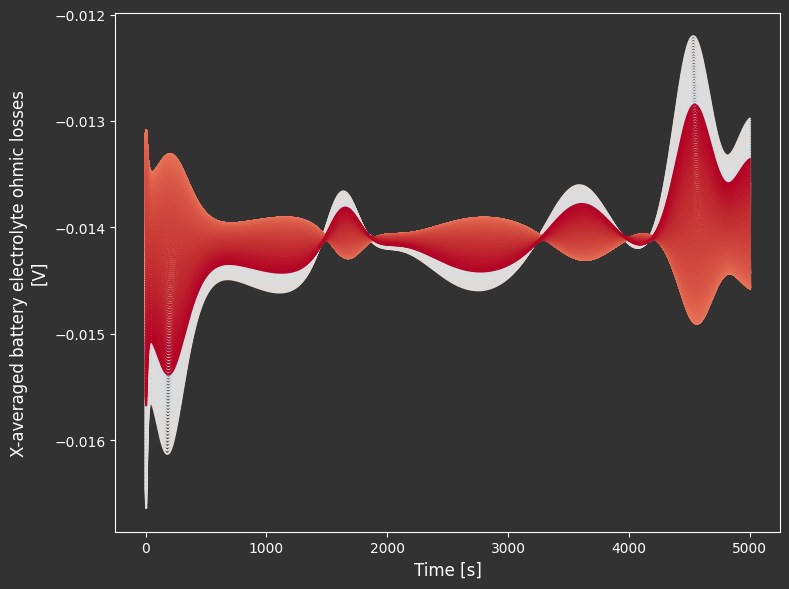

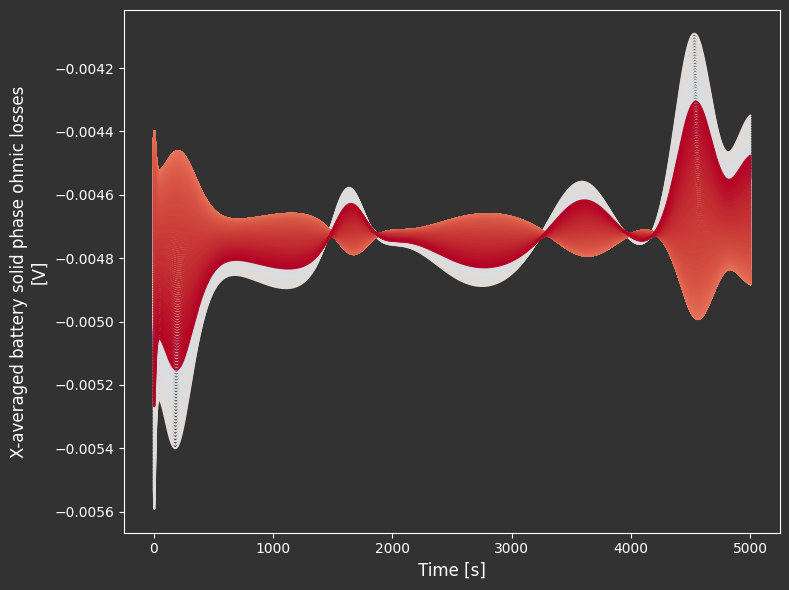

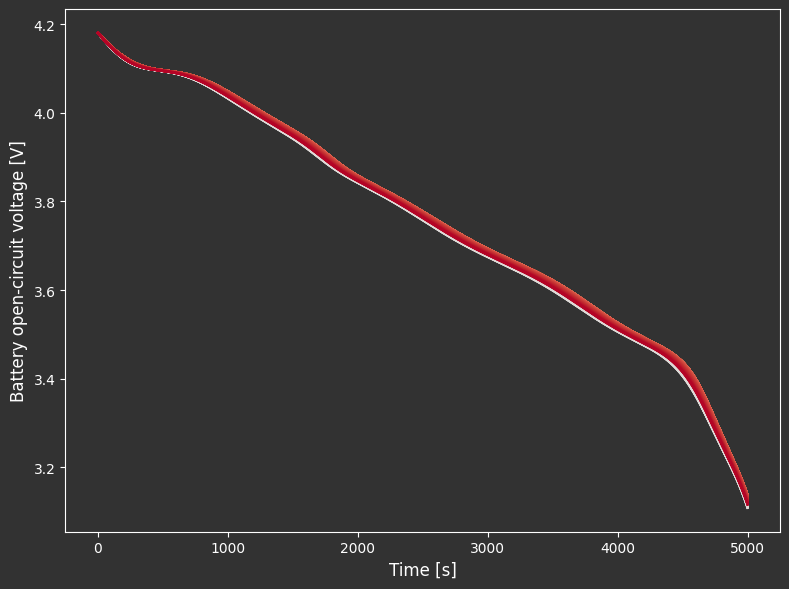

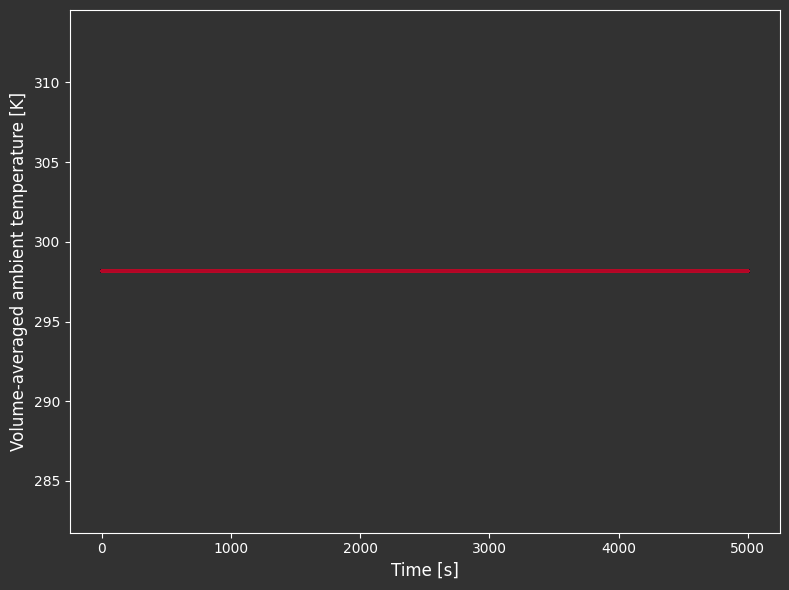

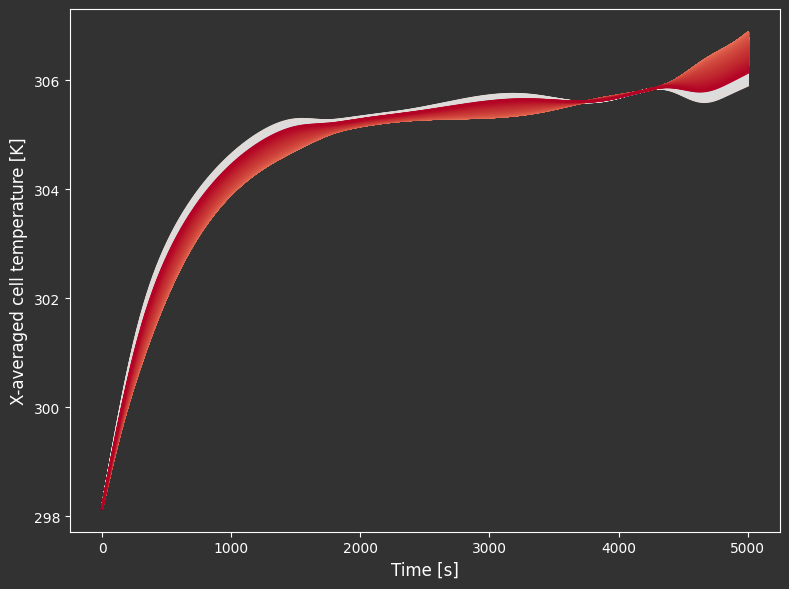

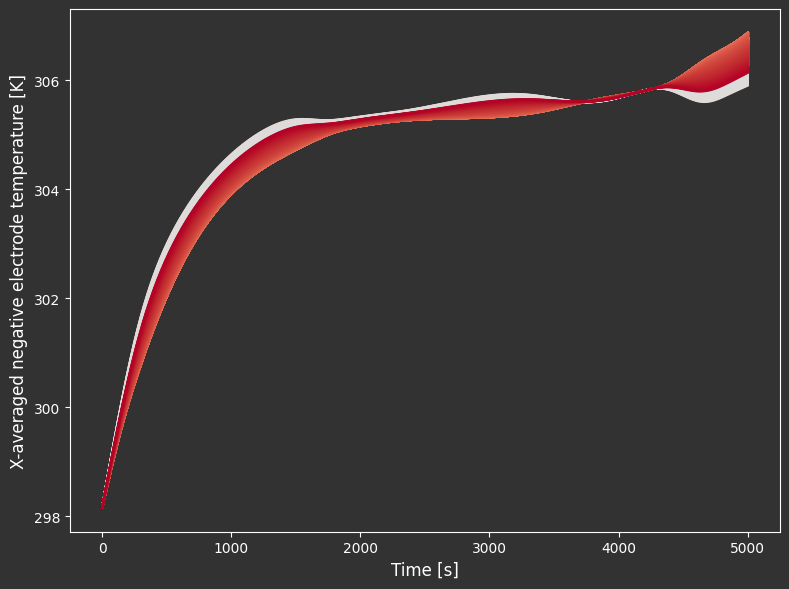

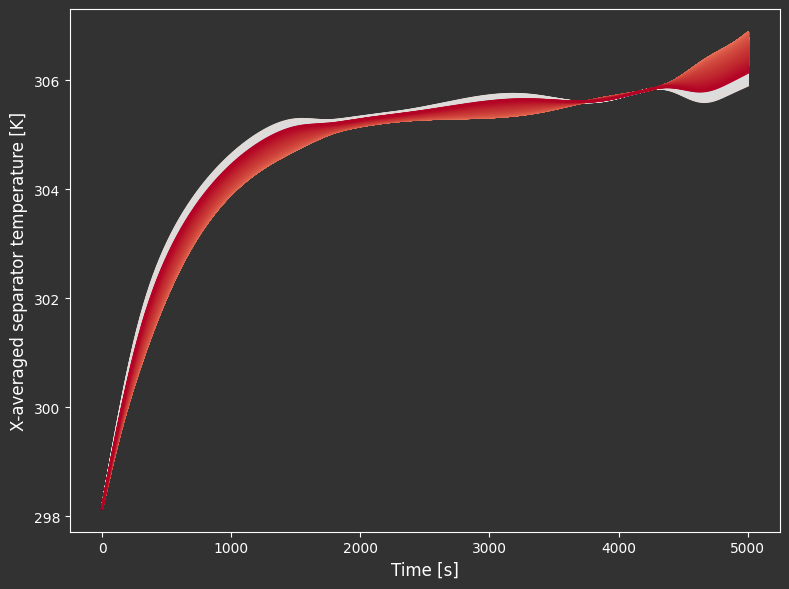

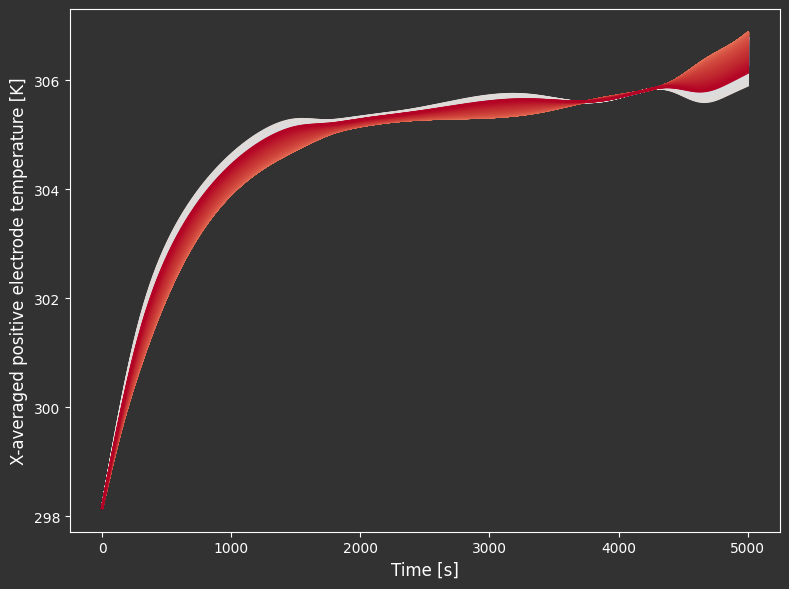

In [10]:
lp.plot_output(output)

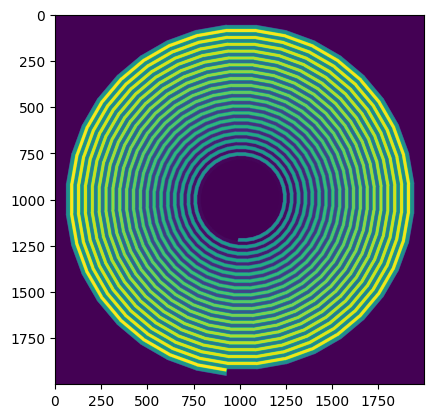

In [10]:
im_spm_map = ecm.interpolate_spm_number(project).astype(int)

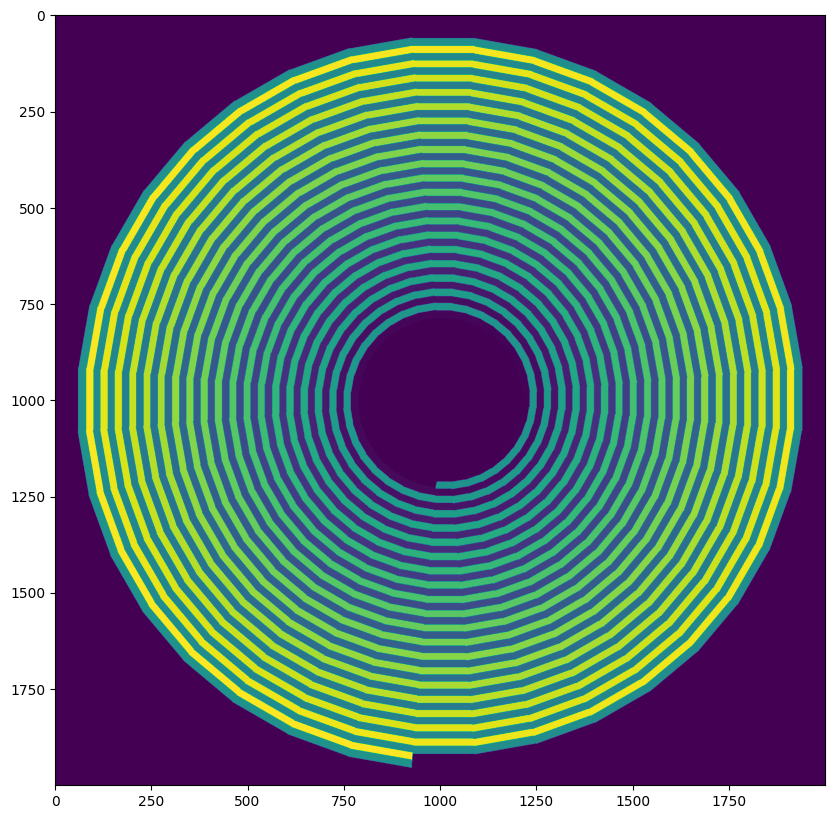

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [12]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [13]:
mask = im_spm_map == -1

In [14]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Battery open-circuit voltage [V]', 'Volume-averaged ambient temperature [K]', 'X-averaged cell temperature [K]', 'X-averaged negative electrode temperature [K]', 'X-averaged separator temperature [K]', 'X-averaged positive electrode temperature [K]'])

In [15]:
t_data = output['Volume-averaged cell temperature [K]'][-1, :]
i_data = output['Current collector current density [A.m-2]'][-1, :]

In [16]:
arr = np.ones_like(im_spm_map).astype(float)

In [17]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

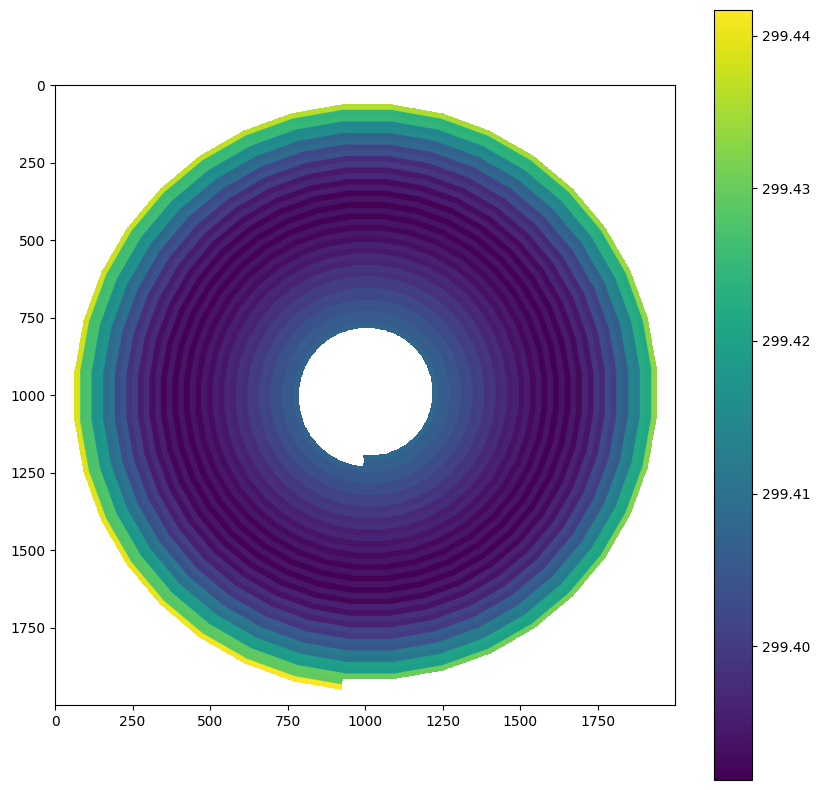

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [19]:
t_data.max() - t_data.min()


0.050445557

In [22]:
# create a gif from the images
import imageio
import os

def make_distr_gif(output,im_spm_map,variable='Volume-averaged cell temperature [K]',path='output.gif'):
    mask = im_spm_map == -1
    # the variable that you want to plot should be taken directly from the output
    all_data = output[variable]
    # all_t_data = output['Volume-averaged cell temperature [K]']
    # all_i_data = output['Current collector current density [A.m-2]']

    # the first index is the time index, the second index is the spatial index

    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]

    # get the min and max temperature over all time points
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)

    # make a matplotlib scalar mappable for colorbar scaling
    norm = plt.Normalize(min_temp, max_temp)


    # loop and pull out the array at each time step
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        # i_data = all_i_data[i, :]
        # create an empty array of the same size as the spatial map
        arr = np.ones_like(im_spm_map).astype(float)
        # use the mask to fill in the array with the data at each time step
        arr[~mask] = t_data[im_spm_map][~mask]
        # set the array at the mask to nan
        arr[mask] = np.nan
        # plot the array and save an image, label the image with the time step
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
        norm = plt.Normalize(min_temp, max_temp)
        im = ax1.imshow(arr,norm=norm,cmap='viridis')
        cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
        cbar.ax.locator_params(nbins=6)
        plt.title(f"Time step {str(i).zfill(3)}")
        plt.savefig(f"output_{str(i).zfill(3)}.png")
        plt.clf()
        plt.close()


    # get the list of files
    files = sorted(os.listdir())
    # filter to only the png files
    files = [f for f in files if f.endswith(".png")]
    # read the images into a list
    images = [imageio.imread(f) for f in files]
    # write the images to a gif
    imageio.mimsave(path, images)
    # delete the images
    for f in files:
        os.remove(f)


make_distr_gif(output,im_spm_map,path='temp_output.gif')
    

In [27]:
# still in dev

import multiprocessing
import mpire
import imageio
import os

def process_time_step(t_data, im_spm_map, mask, min_temp, max_temp, i):
    arr = np.ones_like(im_spm_map).astype(float)
    arr[~mask] = t_data[im_spm_map][~mask]
    arr[mask] = np.nan
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
    norm = plt.Normalize(min_temp, max_temp)
    im = ax1.imshow(arr, norm=norm, cmap='viridis')
    cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
    cbar.ax.locator_params(nbins=6)
    plt.title(f"Time step {str(i).zfill(3)}")
    plt.savefig(f"output_{str(i).zfill(3)}.png")
    plt.clf()
    plt.close()

def make_distr_gif(output, im_spm_map, variable='Volume-averaged cell temperature [K]', path='output.gif'):
    mask = im_spm_map == -1
    all_data = output[variable]
    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)
    norm = plt.Normalize(min_temp, max_temp)

    pool = mpire.WorkerPool()
    results = []
    stacked_t_data = []
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        stacked_t_data.append(t_data)
    result = pool.imap_unordered(process_time_step, (stacked_t_data, im_spm_map, mask, min_temp, max_temp, i))
    # results.append(result)

    # pool.close()
    pool.join()

    files = sorted(os.listdir())
    files = [f for f in files if f.endswith(".png")]
    images = [imageio.imread(f) for f in files]
    imageio.mimsave(path, images)
    for f in files:
        os.remove(f)

make_distr_gif(output, im_spm_map, path='temp_output_mp.gif')
    

ValueError: need at least one array to stack